# Пайплайн <a id='top'></a>

## Imports

In [1]:
import yaml

import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from data_transformer import DataTransformer
from models import BoostingModel
from scorer import ROIChecker

2022-04-22 20:37:27.073130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 20:37:27.073150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# PATHS

In [2]:
DATA_PATH = 'data/all_england_v2.8.csv'
FEATURES_PATH = 'data/features.yaml'

## Load data

In [3]:
raw_train_data = pd.read_csv(DATA_PATH)

with open(FEATURES_PATH) as f:
    all_features_dict = yaml.safe_load(f)

In [4]:
for key, item in all_features_dict.items():
    if isinstance(item, dict):
        print(f"'{key}':")
        for inner_key in item.keys():
            print(f"\t'{inner_key}'")
    else:
        print(f"'{key}'")

        

'base_features'
'scored_features'
'result_coef_features'
'names':
	'team_names'
	'country_names'
	'city_names'
	'manager_names'
'manager_features'
'squad_features':
	'common_features'
	'detail_features'
'city_features'
'money_features'
'coefficients':
	'double_chance_features'
	'total_coef_features'
	'handicap_features'
	'half_features'
	'odd_features'
	'correct_score_features'
	'time_match_features'
	'both_scored_features'


In [5]:
# profile = ProfileReport(raw_train_data, minimal=True)
# profile.to_file("output.html")

## Preprocess data

In [6]:
def base_data_preprocess(data):
    
    preprocessed_data = data.copy()
    
    preprocessed_data['day'] = pd.to_datetime(preprocessed_data.date, format='%d.%m.%Y')
    preprocessed_data['day_of_week'] = preprocessed_data['day'].dt.day_name()
    preprocessed_data['year'] = preprocessed_data['day'].dt.year
    preprocessed_data.date = preprocessed_data.day.values.astype(np.int64) // 10 ** 9
    preprocessed_data.country = 'England'
    preprocessed_data = preprocessed_data.sort_values(by='date')
    preprocessed_data = preprocessed_data.drop(columns=['link'])
    drop_index = preprocessed_data[preprocessed_data.home_goalkeepers_average_age.isna()].index
    preprocessed_data = preprocessed_data.drop(index=drop_index)

    return preprocessed_data

In [7]:
train_data = base_data_preprocess(raw_train_data)

train_data.tail(5)

,date,time,day_of_week,season,country,league,league_level,home_team,away_team,home_win_rate,draw_rate,away_win_rate,home_double_chance_rate,away_double_chance_rate,no_draw_rate,total_over_1_rate,total_under_1_rate,total_over_15_rate,total_under_15_rate,total_over_2_rate,total_under_2_rate,total_over_25_rate,total_under_25_rate,total_over_3_rate,total_under_3_rate,total_over_35_rate,total_under_35_rate,both_team_to_score_yes,both_team_to_score_no,home_handicap_0,away_handicap_0,home_handicap_minus_15,away_handicap_minus_15,home_handicap_minus_1,away_handicap_minus_1,home_handicap_plus_15,away_handicap_plus_15,home_handicap_plus_1,away_handicap_plus_1,home_first_half_handicap_0,away_first_half_handicap_0,home_first_half_handicap_minus_15,away_first_half_handicap_minus_15,home_first_half_handicap_minus_1,away_first_half_handicap_minus_1,home_first_half_handicap_plus_15,away_first_half_handicap_plus_15,home_first_half_handicap_plus_1,away_first_half_handicap_plus_1,home_second_half_handicap_0,away_second_half_handicap_0,home_second_half_handicap_minus_15,away_second_half_handicap_minus_15,home_second_half_handicap_minus_1,away_second_half_handicap_minus_1,home_second_half_handicap_plus_15,away_second_half_handicap_plus_15,home_second_half_handicap_plus_1,away_second_half_handicap_plus_1,home_first_half_win_rate,draw_first_half_rate,away_first_half_win_rate,home_second_half_win_rate,draw_second_half_rate,away_second_half_win_rate,home_double_chance_first_half_rate,away_double_chance_first_half_rate,no_draw_first_half_rate,home_double_chance_second_half_rate,away_double_chance_second_half_rate,no_draw_second_half_rate,total_first_half_over_05_rate,total_first_half_under_05_rate,total_first_half_over_1_rate,total_first_half_under_1_rate,total_first_half_over_15_rate,total_first_half_under_15_rate,total_first_half_over_2_rate,total_first_half_under_2_rate,total_second_half_over_05_rate,total_second_half_under_05_rate,total_second_half_over_1_rate,total_second_half_under_1_rate,total_second_half_over_15_rate,total_second_half_under_15_rate,total_second_half_over_2_rate,total_second_half_under_2_rate,both_team_to_score_first_half_yes,both_team_to_score_first_half_no,both_team_to_score_second_half_yes,both_team_to_score_second_half_no,odd,even,odd_first,odd_second,even_first,even_second,correct_score10,correct_score20,correct_score21,correct_score30,correct_score31,correct_score32,correct_score40,correct_score41,correct_score00,correct_score11,correct_score22,correct_score33,correct_score01,correct_score02,correct_score12,correct_score03,correct_score13,correct_score23,correct_score04,correct_score14,home_home,home_draw,home_away,draw_home,draw_draw,draw_away,away_home,away_draw,away_away,home_scored,away_scored,home_first_half_scored,away_first_half_scored,home_second_half_scored,away_second_half_scored,home_manager_working_days,away_manager_working_days,home_manager_name,away_manager_name,home_manager_start_date,home_manager_birthday,home_manager_country,away_manager_start_date,away_manager_birthday,away_manager_country,month,home_squad_size,home_average_age,home_amount_of_foreigners,home_e_market_value,home_total_market_value,away_squad_size,away_average_age,away_amount_of_foreigners,away_e_market_value,away_total_market_value,home_stadium,home_stadium_capacity,home_city,away_city,is_derby,home_goalkeepers_average_age,home_defenders_average_age,home_midfields_average_age,home_attacks_average_age,home_goalkeepers_total_market_value,home_defenders_total_market_value,home_midfields_total_market_value,home_attacks_total_market_value,home_goalkeepers_e_market_value,home_defenders_e_market_value,home_midfields_e_market_value,home_attacks_e_market_value,home_is_manager_and_league_same_country,away_goalkeepers_average_age,away_defenders_average_age,away_midfields_average_age,away_attacks_average_age,away_goalkeepers_total_market_value,away_defenders_total_market_value,away_midfields_total_market_value,away_attacks_total_market_value,away_goal

In [8]:
train_data.shape

(9655, 210)

In [9]:
nan_count = train_data.isna().sum().sort_values(ascending=False)
nan_count = nan_count[nan_count > 0]
nan_col_index = nan_count.index
nan_count

home_first_half_handicap_plus_15      160
home_first_half_handicap_plus_1       104
home_handicap_plus_15                  73
away_first_half_handicap_minus_15      42
home_second_half_handicap_plus_15      41
home_handicap_plus_1                   37
away_first_half_handicap_minus_1       27
home_second_half_handicap_plus_1       23
total_over_1_rate                      20
away_handicap_minus_15                 14
away_second_half_handicap_minus_15     13
away_handicap_minus_1                  13
away_second_half_handicap_minus_1       4
home_handicap_0                         2
dtype: int64

In [10]:
def prepare_for_yaml(features_list) -> str:
    
    result_yaml = ''
    
    for feature in features_list:
        result_yaml += f"- '{feature}'\n"
        
    return result_yaml

<a id='transformer'></a>
# Трансформер 

[наверх](#top)

In [11]:
numeric_features = tuple(train_data.select_dtypes(include=['int', 'float']).columns)
print(prepare_for_yaml(numeric_features[:10]))
print(f'Number of numeric features: {len(numeric_features)}')

- 'date'
- 'league_level'
- 'home_win_rate'
- 'draw_rate'
- 'away_win_rate'
- 'home_double_chance_rate'
- 'away_double_chance_rate'
- 'no_draw_rate'
- 'total_over_1_rate'
- 'total_under_1_rate'

Number of numeric features: 195


In [12]:
categorical_features = tuple(train_data.select_dtypes(include=['object']).columns)
print(prepare_for_yaml(categorical_features))
print(f'Number of numeric features: {len(categorical_features)}')

- 'time'
- 'day_of_week'
- 'season'
- 'country'
- 'league'
- 'home_team'
- 'away_team'
- 'home_manager_name'
- 'away_manager_name'
- 'home_manager_country'
- 'away_manager_country'
- 'home_stadium'
- 'home_city'
- 'away_city'

Number of numeric features: 14


In [13]:
features = {'cat_features':categorical_features,
            'num_features':numeric_features,
            'grouped_features':all_features_dict
           }

transformer_context = {'data':train_data,
                       'features':features
                      }

transformer = DataTransformer(transformer_context)

In [14]:
%%time
train, val, test, decode_labels, encode_labels = transformer.run_logic()

All categorical features are already encoded!
Features are already generated!
CPU times: user 9.97 s, sys: 40.3 ms, total: 10 s
Wall time: 10 s


In [15]:
test.sample(5)

,date,time,day_of_week,season,country,league,league_level,home_team,away_team,home_win_rate,draw_rate,away_win_rate,home_double_chance_rate,away_double_chance_rate,no_draw_rate,total_over_1_rate,total_under_1_rate,total_over_15_rate,total_under_15_rate,total_over_2_rate,total_under_2_rate,total_over_25_rate,total_under_25_rate,total_over_3_rate,total_under_3_rate,total_over_35_rate,total_under_35_rate,both_team_to_score_yes,both_team_to_score_no,home_handicap_0,away_handicap_0,home_handicap_minus_15,away_handicap_minus_15,home_handicap_minus_1,away_handicap_minus_1,home_handicap_plus_15,away_handicap_plus_15,home_handicap_plus_1,away_handicap_plus_1,home_first_half_handicap_0,away_first_half_handicap_0,home_first_half_handicap_minus_15,away_first_half_handicap_minus_15,home_first_half_handicap_minus_1,away_first_half_handicap_minus_1,home_first_half_handicap_plus_15,away_first_half_handicap_plus_15,home_first_half_handicap_plus_1,away_first_half_handicap_plus_1,home_second_half_handicap_0,away_second_half_handicap_0,home_second_half_handicap_minus_15,away_second_half_handicap_minus_15,home_second_half_handicap_minus_1,away_second_half_handicap_minus_1,home_second_half_handicap_plus_15,away_second_half_handicap_plus_15,home_second_half_handicap_plus_1,away_second_half_handicap_plus_1,home_first_half_win_rate,draw_first_half_rate,away_first_half_win_rate,home_second_half_win_rate,draw_second_half_rate,away_second_half_win_rate,home_double_chance_first_half_rate,away_double_chance_first_half_rate,no_draw_first_half_rate,home_double_chance_second_half_rate,away_double_chance_second_half_rate,no_draw_second_half_rate,total_first_half_over_05_rate,total_first_half_under_05_rate,total_first_half_over_1_rate,total_first_half_under_1_rate,total_first_half_over_15_rate,total_first_half_under_15_rate,total_first_half_over_2_rate,total_first_half_under_2_rate,total_second_half_over_05_rate,total_second_half_under_05_rate,total_second_half_over_1_rate,total_second_half_under_1_rate,total_second_half_over_15_rate,total_second_half_under_15_rate,total_second_half_over_2_rate,total_second_half_under_2_rate,both_team_to_score_first_half_yes,both_team_to_score_first_half_no,both_team_to_score_second_half_yes,both_team_to_score_second_half_no,odd,even,odd_first,odd_second,even_first,even_second,correct_score10,correct_score20,correct_score21,correct_score30,correct_score31,correct_score32,correct_score40,correct_score41,correct_score00,correct_score11,correct_score22,correct_score33,correct_score01,correct_score02,correct_score12,correct_score03,correct_score13,correct_score23,correct_score04,correct_score14,home_home,home_draw,home_away,draw_home,draw_draw,draw_away,away_home,away_draw,away_away,home_manager_working_days,away_manager_working_days,home_manager_name,away_manager_name,home_manager_start_date,home_manager_birthday,home_manager_country,away_manager_start_date,away_manager_birthday,away_manager_country,month,home_squad_size,home_average_age,home_amount_of_foreigners,home_e_market_value,home_total_market_value,away_squad_size,away_average_age,away_amount_of_foreigners,away_e_market_value,away_total_market_value,home_stadium,home_stadium_capacity,home_city,away_city,is_derby,home_goalkeepers_average_age,home_defenders_average_age,home_midfields_average_age,home_attacks_average_age,home_goalkeepers_total_market_value,home_defenders_total_market_value,home_midfields_total_market_value,home_attacks_total_market_value,home_goalkeepers_e_market_value,home_defenders_e_market_value,home_midfields_e_market_value,home_attacks_e_market_value,home_is_manager_and_league_same_country,away_goalkeepers_average_age,away_defenders_average_age,away_midfields_average_age,away_attacks_average_age,away_goalkeepers_total_market_value,away_defenders_total_market_value,away_midfields_total_market_value,away_attacks_total_market_value,away_goalkeepers_e_market_value,away_defenders_e_market_value,away_midfields_e_market_value,away_attacks_e_market_value,away_is

In [16]:
train.target.value_counts()

3    4135
0    2947
1    2503
Name: target, dtype: int64

In [17]:
print(f"Class_0 rate {np.round(train.target.value_counts()[0] / train.shape[0],2)*100}%")
print(f"Class_1 rate {np.round(train.target.value_counts()[1] / train.shape[0],2)*100}%")
print(f"Class_3 rate {np.round(train.target.value_counts()[3] / train.shape[0],2)*100}%")

Class_0 rate 31.0%
Class_1 rate 26.0%
Class_3 rate 43.0%


# <a id='model'></a> Model  
[go to transformer](#transformer)

[go to top](#top)

In [18]:
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from catboost import CatBoostClassifier, Pool

In [19]:
cat_features = list(categorical_features)

model_data = {
    'train':train,
    'val':val,
    'test':test,
    'target':'target',
    'cat_features':cat_features
}

In [20]:
model_params = {'n_estimators':1500,
                'learning_rate':0.1,
                'loss_function':'MultiClass',
                'max_depth':4,
                'task_type':'GPU',
                'early_stopping_rounds':100,
                'verbose':250
                }

model = BoostingModel(params=model_params, data=model_data)

model.fit()


0:	learn: 1.0834239	test: 1.0924638	best: 1.0924638 (0)	total: 8.22ms	remaining: 12.3s
bestTest = 1.065372314
bestIteration = 19
Shrink model to first 20 iterations.


In [21]:
X_test = test.drop(columns=['target'])
y_test = test.target

preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

# Оценка качества

In [22]:
print(f'Validation ACCURACY SCORE: {accuracy_score(y_test, preds_class)}')

Validation ACCURACY SCORE: 0.55


In [23]:
print(f'Validation ROC AUC SCORE: {roc_auc_score(y_test, preds_proba, multi_class="ovr")}')

Validation ROC AUC SCORE: 0.4644510582010582


In [24]:
train_preds_class = model.model.predict(train.drop(columns=['target']))

In [25]:
train_preds_df = pd.DataFrame()
train_preds_df['pred_class'] = train_preds_class.ravel()

In [26]:
print('True target rate: ')
print(f"Class_0 rate {train.target.value_counts()[0] / train.shape[0]}")
print(f"Class_1 rate {train.target.value_counts()[1] / train.shape[0]}")
print(f"Class_3 rate {train.target.value_counts()[3] / train.shape[0]}")

True target rate: 
Class_0 rate 0.30745957224830467
Class_1 rate 0.26113719353155973
Class_3 rate 0.43140323422013566


In [27]:
train_preds_df.pred_class.value_counts()

3    6748
0    2837
Name: pred_class, dtype: int64

In [28]:
print('Predict target rate:')
print(f"Class_0 rate {train_preds_df.pred_class.value_counts()[0] / train_preds_df.shape[0]}")
# print(f"Class_1 rate {train_preds_df.pred_class.value_counts()[1] / train_preds_df.shape[0]}")
print(f"Class_3 rate {train_preds_df.pred_class.value_counts()[3] / train_preds_df.shape[0]}")

Predict target rate:
Class_0 rate 0.2959833072509129
Class_3 rate 0.7040166927490871


In [29]:
scorer = ROIChecker(decode_labels=decode_labels['team_names'])

In [30]:
scorer.run_check(X_test, y_test, preds_proba, preds_class)

In [31]:
X_val, y_val = val.drop(columns=['target']), val.target
preds_class_val = model.model.predict(X_val)
preds_proba_val = model.model.predict_proba(X_val)

In [32]:
scorer.run_check(X_val, y_val, preds_proba_val, preds_class_val)

In [33]:
dynamic_info, static_info = scorer.return_info()

In [34]:
static_info[2]

[1000, 1844.0, 2544.0]

<AxesSubplot:>

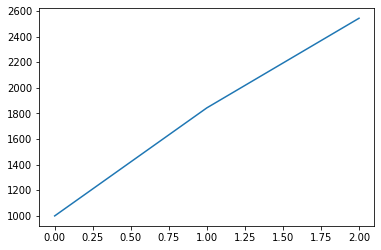

In [35]:
sns.lineplot(x=[i for i in range(len(static_info[2]))], y=static_info[2])

# [НАВЕРХ](#top)

# Timeseries crossvalidation

In [36]:
train = train.reset_index()
train = train.drop(columns=['index'])
train.head(5)

,date,time,day_of_week,season,country,league,league_level,home_team,away_team,home_win_rate,draw_rate,away_win_rate,home_double_chance_rate,away_double_chance_rate,no_draw_rate,total_over_1_rate,total_under_1_rate,total_over_15_rate,total_under_15_rate,total_over_2_rate,total_under_2_rate,total_over_25_rate,total_under_25_rate,total_over_3_rate,total_under_3_rate,total_over_35_rate,total_under_35_rate,both_team_to_score_yes,both_team_to_score_no,home_handicap_0,away_handicap_0,home_handicap_minus_15,away_handicap_minus_15,home_handicap_minus_1,away_handicap_minus_1,home_handicap_plus_15,away_handicap_plus_15,home_handicap_plus_1,away_handicap_plus_1,home_first_half_handicap_0,away_first_half_handicap_0,home_first_half_handicap_minus_15,away_first_half_handicap_minus_15,home_first_half_handicap_minus_1,away_first_half_handicap_minus_1,home_first_half_handicap_plus_15,away_first_half_handicap_plus_15,home_first_half_handicap_plus_1,away_first_half_handicap_plus_1,home_second_half_handicap_0,away_second_half_handicap_0,home_second_half_handicap_minus_15,away_second_half_handicap_minus_15,home_second_half_handicap_minus_1,away_second_half_handicap_minus_1,home_second_half_handicap_plus_15,away_second_half_handicap_plus_15,home_second_half_handicap_plus_1,away_second_half_handicap_plus_1,home_first_half_win_rate,draw_first_half_rate,away_first_half_win_rate,home_second_half_win_rate,draw_second_half_rate,away_second_half_win_rate,home_double_chance_first_half_rate,away_double_chance_first_half_rate,no_draw_first_half_rate,home_double_chance_second_half_rate,away_double_chance_second_half_rate,no_draw_second_half_rate,total_first_half_over_05_rate,total_first_half_under_05_rate,total_first_half_over_1_rate,total_first_half_under_1_rate,total_first_half_over_15_rate,total_first_half_under_15_rate,total_first_half_over_2_rate,total_first_half_under_2_rate,total_second_half_over_05_rate,total_second_half_under_05_rate,total_second_half_over_1_rate,total_second_half_under_1_rate,total_second_half_over_15_rate,total_second_half_under_15_rate,total_second_half_over_2_rate,total_second_half_under_2_rate,both_team_to_score_first_half_yes,both_team_to_score_first_half_no,both_team_to_score_second_half_yes,both_team_to_score_second_half_no,odd,even,odd_first,odd_second,even_first,even_second,correct_score10,correct_score20,correct_score21,correct_score30,correct_score31,correct_score32,correct_score40,correct_score41,correct_score00,correct_score11,correct_score22,correct_score33,correct_score01,correct_score02,correct_score12,correct_score03,correct_score13,correct_score23,correct_score04,correct_score14,home_home,home_draw,home_away,draw_home,draw_draw,draw_away,away_home,away_draw,away_away,home_manager_working_days,away_manager_working_days,home_manager_name,away_manager_name,home_manager_start_date,home_manager_birthday,home_manager_country,away_manager_start_date,away_manager_birthday,away_manager_country,month,home_squad_size,home_average_age,home_amount_of_foreigners,home_e_market_value,home_total_market_value,away_squad_size,away_average_age,away_amount_of_foreigners,away_e_market_value,away_total_market_value,home_stadium,home_stadium_capacity,home_city,away_city,is_derby,home_goalkeepers_average_age,home_defenders_average_age,home_midfields_average_age,home_attacks_average_age,home_goalkeepers_total_market_value,home_defenders_total_market_value,home_midfields_total_market_value,home_attacks_total_market_value,home_goalkeepers_e_market_value,home_defenders_e_market_value,home_midfields_e_market_value,home_attacks_e_market_value,home_is_manager_and_league_same_country,away_goalkeepers_average_age,away_defenders_average_age,away_midfields_average_age,away_attacks_average_age,away_goalkeepers_total_market_value,away_defenders_total_market_value,away_midfields_total_market_value,away_attacks_total_market_value,away_goalkeepers_e_market_value,away_defenders_e_market_value,away_midfields_e_market_value,away_attacks_e_market_value,away_is

In [40]:
# current_features = list(train.filter(like='current').columns)

In [41]:
# base_cv_features = all_features_dict['base_features'] + current_features + ['target']
# base_train = train[base_cv_features]
# base_train.head()

In [42]:
# cat_features = [feature for feature in base_cv_features if feature in categorical_features]
# cat_features

In [43]:
# base_val = val[base_cv_features]
# base_test = test[base_cv_features]

In [81]:
def get_cv_data(train_data, train_initial_size=7000, window=50):
    
    for index in range(0, train_data.shape[0] - train_initial_size - window + 1, window):
        
        train_cv = train_data.loc[:train_initial_size + index]
        val_cv = train_data.loc[train_initial_size + index: train_initial_size + index + window]
        yield train_cv, val_cv

In [82]:
cv_scorer = ROIChecker(decode_labels=decode_labels['team_names'])

In [83]:
model_params = {'n_estimators':1500,
                'learning_rate':0.1,
                'loss_function':'MultiClass',
                'task_type':'GPU',
                'early_stopping_rounds':50,
                'verbose':750
                }

cv_model = CatBoostClassifier(**model_params)

In [84]:
# cv_train_columns = {index:feature for index, feature in enumerate(list(cv_X_train.columns))}
# cv_train_columns

In [85]:
# cv_test_columns = {index:feature for index, feature in enumerate(list(cv_X_test.columns))}
# cv_test_columns

In [86]:
%%time
iteration = 0
for cv_train, cv_test in get_cv_data(train):
    cv_y_train = cv_train.target
    cv_X_train = cv_train.drop(columns=['target'])
    cv_y_test = cv_test.target
    cv_X_test = cv_test.drop(columns=['target'])

    cv_model.fit(cv_X_train, cv_y_train)
    
    preds_proba = cv_model.predict_proba(cv_X_test)
    preds_class = cv_model.predict(cv_X_test)
    
    cv_scorer.run_check(cv_X_test, cv_y_test, preds_proba, preds_class)
    
    iteration += 1
    print(f"Iretation #{iteration} complete!")
    print('_______')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.0831648	total: 15ms	remaining: 22.5s
750:	learn: 0.4741542	total: 9.82s	remaining: 9.79s
1499:	learn: 0.2468998	total: 19.3s	remaining: 0us
Iretation #1 complete!
_______
0:	learn: 1.0833740	total: 12.3ms	remaining: 18.5s
750:	learn: 0.4765102	total: 9.47s	remaining: 9.45s
1499:	learn: 0.2557754	total: 19s	remaining: 0us
Iretation #2 complete!
_______
0:	learn: 1.0833234	total: 14ms	remaining: 21s
750:	learn: 0.4793361	total: 9.35s	remaining: 9.33s
1499:	learn: 0.2540911	total: 18.7s	remaining: 0us
Iretation #3 complete!
_______
0:	learn: 1.0834190	total: 14.1ms	remaining: 21.2s
750:	learn: 0.4817185	total: 9.48s	remaining: 9.46s
1499:	learn: 0.2584330	total: 19s	remaining: 0us
Iretation #4 complete!
_______
0:	learn: 1.0836745	total: 14ms	remaining: 21s
750:	learn: 0.4759676	total: 9.55s	remaining: 9.53s
1499:	learn: 0.2554516	total: 19.4s	remaining: 0us
Iretation #5 complete!
_______
0:	learn: 1.0836593	total: 15.1ms	remaining: 22.6s
750:	learn: 0.4837073	total: 9.42s	rem

1499:	learn: 0.3191434	total: 19.6s	remaining: 0us
Iretation #45 complete!
_______
0:	learn: 1.0836045	total: 15.9ms	remaining: 23.9s
750:	learn: 0.5525063	total: 9.61s	remaining: 9.59s
1499:	learn: 0.3247158	total: 19.4s	remaining: 0us
Iretation #46 complete!
_______
0:	learn: 1.0835899	total: 13.6ms	remaining: 20.4s
750:	learn: 0.5506015	total: 9.97s	remaining: 9.94s
1499:	learn: 0.3220202	total: 19.9s	remaining: 0us
Iretation #47 complete!
_______
0:	learn: 1.0836133	total: 13.7ms	remaining: 20.5s
750:	learn: 0.5534639	total: 9.74s	remaining: 9.72s
1499:	learn: 0.3226805	total: 19.7s	remaining: 0us
Iretation #48 complete!
_______
0:	learn: 1.0835933	total: 14.9ms	remaining: 22.4s
750:	learn: 0.5537693	total: 9.96s	remaining: 9.93s
1499:	learn: 0.3270026	total: 19.9s	remaining: 0us
Iretation #49 complete!
_______
0:	learn: 1.0836305	total: 13.8ms	remaining: 20.7s
750:	learn: 0.5542070	total: 9.88s	remaining: 9.85s
1499:	learn: 0.3260540	total: 19.7s	remaining: 0us
Iretation #50 compl

In [87]:
dynamic_info, static_info = cv_scorer.return_info()

In [ ]:
for info in static_info[0]:
    

<AxesSubplot:>

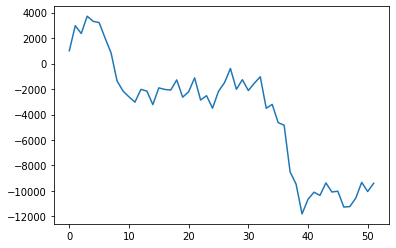

In [88]:
sns.lineplot(x=[i for i in range(len(static_info[2]))], y=static_info[2])

<AxesSubplot:>

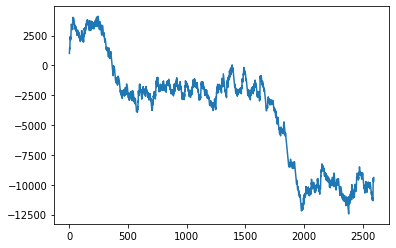

In [89]:
sns.lineplot(x=[i for i in range(len(static_info[1]))], y=static_info[1])

# Считаем ROI - "коэффициент выгодности ставки"

In [ ]:
class ROIChecker():
    def __init__(self, predictions):
        self.predictions = predictions
    
    def get_roi(self):
        
        self.predictions['home_win_ROI'] = self.predictions.home_win_rate * self.predictions.home_win_proba - 1
        self.predictions['away_win_ROI'] = self.predictions.away_win_rate * self.predictions.away_win_proba - 1
        self.predictions['draw_ROI'] = self.predictions.draw_rate * self.predictions.draw_proba - 1
        
        return self.predictions
    

In [ ]:
checker = ROIChecker(test_predictions)
roi_info = checker.get_roi()

In [ ]:
roi_info.head()

In [ ]:
def explain_roi_info(roi_info):
    roi_cols = ['home_win_ROI', 'away_win_ROI', 'draw_ROI']
    best_roi_df = pd.DataFrame()
    for index, row in roi_info.iterrows():
        print(f"Match #{index+1}: {row.home_team} vs {row.away_team}")
        
        max_roi = np.max(roi_info.loc[index, roi_cols])
        current_choice = 'home_win_ROI'
        
        for col in roi_cols:
            if row[col] == max_roi:
                current_choice = col
        current_choice = ' '.join(current_choice.split('_')[:1])
        
        if max_roi > 0:
            print(f"Maximal ROI = {np.round(max_roi*100,2)}% on {current_choice}")
        
        else:
            print("Нет положительного ROI")
            
        print('_______________________________ \n')
        
        best_roi_df.loc[index, 'home_team'] = row.home_team
        best_roi_df.loc[index, 'away_team'] = row.away_team
        best_roi_df.loc[index, 'best_ROI'] = max_roi
        best_roi_df.loc[index, 'choice'] = current_choice
        best_roi_df.loc[index, 'home_win_rate'] = row.home_win_rate
        best_roi_df.loc[index, 'draw_rate'] = row.draw_rate
        best_roi_df.loc[index, 'away_win_rate'] = row.away_win_rate
        best_roi_df.loc[index, 'result'] = row.result
        best_roi_df.loc[index, 'predict'] = row.predict

        
    return best_roi_df

In [ ]:
best_roi_df = explain_roi_info(roi_info)

In [ ]:
best_roi_df

In [ ]:
def money_score(best_roi_df, bet=100):
    results = {'home':3, 'draw':1, 'away':0}
    cols = {'home':'home_win_rate', 'draw':'draw_rate', 'away':'away_win_rate'}
    profit = 0
    skipped_bets = 0
    accepted_bets = 0
    total_coef = 0
    win_coef = 0
    lose_coef = 0
    win_bets = 0
    lose_bets = 0
    total_bank = 0
    win_bank = 0
    lose_bank = 0
    
    for index, row in best_roi_df.iterrows():
        if row.best_ROI < 0:
                skipped_bets += 1
        else:
            accepted_bets += 1

            if results[row.choice] == row.result:

                current_profit = bet * (row[cols[row.choice]] - 1)
                profit += current_profit
                win_coef += row[cols[row.choice]]

                print(f'Match {row.home_team} vs {row.away_team}')
                print(row.choice, row[cols[row.choice]], current_profit)
                print(f'Match score ')
                print('_____________________________________________________\n')
                win_bank += current_profit
                win_bets += 1
                
            else:
                profit -= bet
                lose_bank -= bet
                lose_bets += 1
                lose_coef += row[cols[row.choice]]
                
            total_coef += row[cols[row.choice]]
            total_bank += bet

    average_win_coef = win_coef / win_bets

    average_lose_coef = lose_coef / lose_bets
    average_coef = total_coef / accepted_bets
    percent_profit = profit / total_bank * 100
          
    result = ((skipped_bets, accepted_bets),
            (profit, percent_profit),
            (total_bank, win_bank, lose_bank),
            (win_bets, lose_bets),
            (average_coef, average_win_coef, average_lose_coef))
    
    return result
    

In [ ]:
score = money_score(best_roi_df, 100)

In [ ]:
print(f'Skipped bets: {score[0][0]}\t Accepted bets: {score[0][1]}')
print(f"Win bets: {score[3][0]}\t Lose bets: {score[3][1]}")
print(f"Win bank: {score[2][1]}$\t Lose bank: {score[2][2]}$")

print(f"Average coefficient: {np.round(score[4][0],2)}")
print(f"Avg win coef: {np.round(score[4][1],2)}\t Avg lose coef: {np.round(score[4][2],2)}")
print(f"Initial bank was {score[2][0]}$ \t Finish bank is {score[2][0]+np.round(score[1][0],2)}$\n")
print('___________RESULT__________')
print(f" \tWe get + {np.round(score[1][1],2)}% profit")
print(f" \tProfit: {score[1][0]}$")

# Влияние фичей на качество модели

In [ ]:
feature_importance = model.get_feature_importances()
feature_importance_df = pd.DataFrame()

feature_importance_df['feature'] = X_test.columns
feature_importance_df['importance'] = feature_importance

good_features = feature_importance_df[np.abs(feature_importance_df.importance) > 0].sort_values(by='importance',ascending=False).head(30)
bad_features = feature_importance_df.sort_values(by='importance',ascending=True).head(30)

print(f'Number of features {X_test.shape[1]}')

In [ ]:
good_features

In [ ]:
bad_features

In [ ]:
test_predictions = pd.DataFrame()
test_predictions['home_team'] = X_test.home_team.map(decode_labels['team_names'])
test_predictions['away_team'] = X_test.away_team.map(decode_labels['team_names'])
test_predictions['home_win_proba'] = preds_proba[:,0]
test_predictions['draw_proba'] = preds_proba[:,1]
test_predictions['away_win_proba'] = preds_proba[:,2]
test_predictions['home_win_rate'] = X_test.home_win_rate
test_predictions['draw_rate'] = X_test.draw_rate
test_predictions['away_win_rate'] = X_test.away_win_rate
test_predictions['result'] = y_test
test_predictions['predict'] = preds_class

In [ ]:
test_predictions

## Generating some features and testing hypotheses

# ПЕРЕДЕЛАТЬ! Считаем сезонные total :
- забитые
- пропущенные
- количество очков

In [ ]:
query = '((home_team == @team) | (away_team == @team)) & (season == @season) & (league == @league)'

season_data = pd.DataFrame()

total_features = train_data_base.copy()

for league in total_features.league.unique():

    for season in total_features.season.unique():
        
        season_league_data = total_features.query('(season == @season) & (league == @league)')
        
        for team in season_league_data.home_team.unique():   
            
            season_data = season_league_data.query('((home_team == @team) | (away_team == @team))')
            
            total_points = 0
            total_scored = 0
            total_missed = 0


            for idx in season_data.index:

                if season_data.loc[idx, 'home_team'] == team:

                    total_points += season_data.loc[idx, 'target']
                    total_scored += season_data.loc[idx, 'home_scored']
                    total_missed += season_data.loc[idx, 'away_scored']

                else:

                    home = season_data.loc[idx, 'home_scored']
                    away = season_data.loc[idx, 'away_scored']

                    away_match_score = 3 if home < away else 1 if home == away else 0

                    total_points += away_match_score
                    total_scored += season_data.loc[idx, 'away_scored']
                    total_missed += season_data.loc[idx, 'home_scored']

            condition_home = ((total_features.home_team == team) & (total_features.season == season))
            condition_away = ((total_features.away_team == team) & (total_features.season == season))
                    
            total_features.loc[condition_home,'total_points_home'] = total_points
            total_features.loc[condition_away,'total_points_away'] = total_points
            
            total_features.loc[condition_home,'total_scored_home'] = total_scored
            total_features.loc[condition_away,'total_scored_away'] = total_scored

            total_features.loc[condition_home,'total_missed_home'] = total_missed
            total_features.loc[condition_away,'total_missed_away'] = total_missed

            total_features.loc[condition_home,'total_diff_home'] = total_scored - total_missed
            total_features.loc[condition_away,'total_diff_away'] = total_scored - total_missed            



            print(f"TEAM: {team} LEAGUE: {league} SEASON: {season}\ntotal points:{total_points}\ttotal scored:{total_scored}\ttotal missed:{total_missed}\ttotal_diff: {total_scored - total_missed}")
            print('_________')
        
total_features.tail()        

In [ ]:
home_team_alltime = train_data_base.groupby(['home_team'], as_index=False) \
                        .agg(home_mean_scored_season = ('home_scored', 'mean'),
                            home_mean_missed_season = ('away_scored', 'mean')                                 
                            )

away_team_alltime = train_data_base.groupby(['away_team'], as_index=False) \
                        .agg(away_mean_scored_alltime = ('home_scored', 'mean'),
                            away_mean_missed_alltime = ('away_scored', 'mean')                                 
                            )

home_team_alltime.head()

In [ ]:
train_data_base = train_data_base.merge(home_team_alltime, how='left', on=['home_team', 'season'])
train_data_base = train_data_base.merge(away_team_alltime, how='left', on=['away_team', 'season'])

train_data_base.head()

# ПЕРЕДЕЛАТЬ! Личные встречи за все время забитые/пропущенные

In [ ]:
# personal_battles = train_with_names.groupby(['home_team', 'away_team'], as_index=False) \
#                         .agg(total_home_scored = ('home_scored', 'sum'),
#                             total_home_missed = ('away_scored', 'sum'),
                            
#                             )

# personal_battles

# Разбиение фичей на группы [ПРОПУСТИТЬ](#numeric)

In [ ]:
enumerated_features = dict()

for idx, feature in enumerate(list(train_data.columns)):
    enumerated_features[idx] = feature

In [ ]:
enumerated_features

In [ ]:
base_features = list(train_data.iloc[0:2, 0:9].columns)
base_features.append(enumerated_features[126])
base_features.append(enumerated_features[127])
base_features.append(enumerated_features[208])
base_features.append(enumerated_features[209])
base_features.append('month')


print(prepare_for_yaml(base_features))

In [ ]:
squad_features = list(train_data.iloc[0:2,143:153].columns)
print(prepare_for_yaml(squad_features))

In [ ]:
squad_detail_features = list(train_data.iloc[0:2, 158:208])
print(prepare_for_yaml(squad_detail_features[:10]))

In [ ]:
money_features = list(train_data.filter(like='market_value', axis=1).columns) + list(train_data.filter(like='s_sum', axis=1).columns)
print(prepare_for_yaml(money_features))

In [ ]:
city_features = list(train_data.iloc[0:2,153:158].columns)
print(prepare_for_yaml(city_features))

In [ ]:
result_coef_features = [enumerated_features[9], enumerated_features[10], enumerated_features[11]]
print(prepare_for_yaml(result_coef_features))

In [ ]:
double_chance_features = list(train_data.filter(like='chance', axis=1).columns)
print(prepare_for_yaml(double_chance_features))

In [ ]:
total_coef_features = list(train_data.filter(like='total_over', axis=1).columns) + list(train_data.filter(like='total_under', axis=1).columns)
print(prepare_for_yaml(total_coef_features))

In [ ]:
handicap_features = list(train_data.iloc[0:2,29:39].columns)
print(prepare_for_yaml(handicap_features))

In [ ]:
half_features = list(train_data.iloc[0:2,39:91].columns)
print(prepare_for_yaml(half_features[:10]))

In [ ]:
odd_features = list(train_data.iloc[0:2,91:97].columns)

print(prepare_for_yaml(odd_features))

In [ ]:
correct_score_features = list(train_data.filter(like='correct_score', axis=1).columns)
print(prepare_for_yaml(correct_score_features))

In [ ]:
time_match_features = list(train_data.iloc[0:2,117:126].columns)
print(prepare_for_yaml(time_match_features))

In [ ]:
both_scored_features = list(train_data.iloc[0:2,87:91].columns)
both_scored_features += list(train_data.iloc[0:2,128:132].columns)
both_scored_features.append(enumerated_features[27])
both_scored_features.append(enumerated_features[28])

print(prepare_for_yaml(both_scored_features))

In [ ]:
manager_features = tuple(train_data.filter(like='manager', axis=1).columns)

print(prepare_for_yaml(manager_features))